# Auditing and training fair ML models

We will:
1. Train standard (unconstrained) model;
2. Check attainable fairness-accuracy trade-offs via post-processing, with the `error-parity` package;
3. Train fairness-constrained model (in-processing fairness intervention), with the `fairlearn` package;
5. Map results for post-processing + in-processing interventions;

---

In [1]:
import os
import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(palette="colorblind", style="whitegrid", rc={"grid.linestyle": "--", "figure.dpi": 200, "figure.figsize": (4,3)})

Some useful global constants:

In [3]:
DATASET_NAME = "UCI_Adult"

DATA_DIR = Path("../data").resolve() / DATASET_NAME
IMGS_DIR = Path("../imgs").resolve() / DATASET_NAME
SEED = 42

TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

PERF_METRIC = "accuracy"
DISP_METRIC = "equalized_odds_diff"

N_JOBS = max(2, os.cpu_count() - 2)

np.random.seed(SEED)

In [4]:
# Images directory
IMGS_DIR.mkdir(exist_ok=True)

def save_current_fig(fig_name: str):
    plt.gcf().savefig(IMGS_DIR / f"{fig_name}.png", bbox_inches="tight")
    plt.gcf().savefig(IMGS_DIR / f"{fig_name}.pdf", bbox_inches="tight")

## Fetch UCI Adult data
> See the companion [`training-fairer-models_large-dataset.ipynb`](training-fairer-models_large-dataset.ipynb) notebook for an example on a much larger dataset.

We'll use the [UCI Adult](https://archive.ics.uci.edu/dataset/2/adult) dataset for this tooling session (~49K samples).



We'll use the `sex` column as the sensitive attribute.
That is, false positive (FP) and false negative (FN) errors should not disproportionately impact individuals based on their sex.

In [5]:
SENSITIVE_COL = "sex"
sensitive_col_map = {"Male": 0, "Female": 1}

# NOTE: You can also try to run this using the `race` column as sensitive attribute (as commented below).
# SENSITIVE_COL = "race"
# sensitive_col_map = {"White": 0, "Black": 1, "Asian-Pac-Islander": 1, "Amer-Indian-Eskimo": 1, "Other": 1}

sensitive_col_inverse = {val: key for key, val in sensitive_col_map.items()}

POS_LABEL = ">50K"

Download data.

In [6]:
from fairlearn.datasets import fetch_adult

X, Y = fetch_adult(
    as_frame=True,
    return_X_y=True,
    data_home=DATA_DIR,
)

# Map labels and sensitive column to numeric data
Y = np.array(Y == POS_LABEL, dtype=int)
S = np.array([sensitive_col_map[elem] for elem in X[SENSITIVE_COL]], dtype=int)

Split in train/test/validation data.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_other, y_train, y_other, s_train, s_other = train_test_split(
    X, Y, S,
    test_size=TEST_SIZE + VALIDATION_SIZE,
    stratify=Y, random_state=SEED,
)

X_val, X_test, y_val, y_test, s_val, s_test = train_test_split(
    X_other, y_other, s_other,
    test_size=TEST_SIZE / (TEST_SIZE + VALIDATION_SIZE),
    stratify=y_other, random_state=SEED,
)

Log the accuracy attainable by a dummy constant classifier.

In [8]:
def compute_constant_clf_accuracy(labels: np.ndarray) -> float:
    return max((labels == const_pred).mean() for const_pred in np.unique(labels))

constant_clf_accuracy = {
    "train": compute_constant_clf_accuracy(y_train),
    "test": compute_constant_clf_accuracy(y_test),
    "validation": compute_constant_clf_accuracy(y_val),
}
constant_clf_accuracy

{'train': 0.7607234260365126,
 'test': 0.7606715119254785,
 'validation': 0.7607493857493858}

## Train standard (unconstrained) classifiers

Let's do random hyperparameter sampling for a few unconstrained classifiers. 

In [9]:
from hpt.tuner import ObjectiveFunction, OptunaTuner
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARN)   # Turn off optuna log notes.

obj_func = ObjectiveFunction(
    X_train=X_train, y_train=y_train, s_train=s_train,
    X_val=X_val, y_val=y_val, s_val=s_val,
    X_test=X_test, y_test=y_test, s_test=s_test,
    hyperparameter_space="gbm-hyperparameter-space.yaml",    # path to YAML file
    eval_metric=PERF_METRIC,
    threshold=0.50,
)

tuner = OptunaTuner(
    objective_function=obj_func,
    direction="maximize",
    seed=SEED,
)

In [10]:
%%time
tuner.optimize(n_trials=20, n_jobs=N_JOBS)

print(f"Best model is {obj_func.best_trial.hyperparameters}")

Best model is {'classpath': 'lightgbm.LGBMClassifier', 'n_jobs': 1, 'verbosity': -1, 'boosting_type': 'gbdt', 'data_sample_strategy': 'goss', 'enable_bundle': False, 'n_estimators': 475, 'num_leaves': 295, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.022941943029131964}
CPU times: user 12.3 s, sys: 86.8 ms, total: 12.4 s
Wall time: 2.8 s


Let's plot the results!

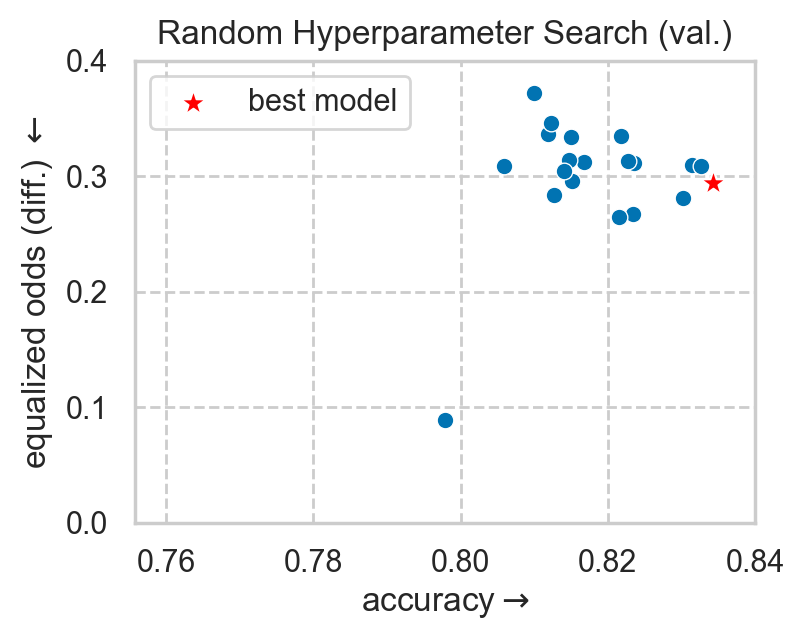

In [11]:
obj_func.plot(x_axis=PERF_METRIC, y_axis=DISP_METRIC, pyplot_show=False)

ax_kwargs = dict(
    xlim=(constant_clf_accuracy["validation"] - 5e-3, 0.84),
    ylim=(0.0, 0.4),
    title="Random Hyperparameter Search (val.)",
    xlabel=PERF_METRIC + r"$\rightarrow$",
    ylabel="equalized odds (diff.) $\leftarrow$" if DISP_METRIC == "equalized_odds_diff" else DISP_METRIC,
)

plt.legend(loc="upper left")
plt.gca().set(**ax_kwargs)
plt.show()

In [12]:
unconstr_clf = obj_func.reconstruct_model(obj_func.best_trial)

## Map attainable fairness-accuracy trade-offs via (relaxed) post-processing

By varying the tolerance (or slack) of the fairness constraint we can map the different trade-offs attainable by the same model (each trade-off corresponds to a different post-processing intervention).

**Post-processing** fairness methods intervene on the predictions of an already trained model, using different (possibly randomized) thresholds to binarize predictions of different groups.

We'll be using the [`error-parity`](https://github.com/socialfoundations/error-parity) package [[Cruz and Hardt, 2023]](https://arxiv.org/abs/2306.07261).

In [13]:
from utils.postprocessing import compute_postprocessing_curve

# Data to fit postprocessing adjustment
fit_data = (X_train, y_train, s_train)
# fit_data = (X_val, y_val, s_val)

# Common kwargs for the `compute_postprocessing_curve` call
compute_postproc_kwargs = dict(
    fit_data=fit_data,
    eval_data={
        "validation": (X_val, y_val, s_val),
        "test": (X_test, y_test, s_test),
    },
    fairness_constraint="equalized_odds",
    tolerance_ticks=np.hstack((
        np.arange(0.0, 0.2, 1e-2),
        np.arange(0.2, 1.0, 1e-1),
    )),
    bootstrap=True,
    n_jobs=N_JOBS,
    seed=SEED,
)

In [14]:
%%time
postproc_results_df = compute_postprocessing_curve(
    model=unconstr_clf,
    y_fit_pred_scores=unconstr_clf.predict_proba(fit_data[0])[:, -1],
    **compute_postproc_kwargs,
)

  0%|          | 0/28 [00:00<?, ?it/s]

CPU times: user 2min 49s, sys: 34.5 s, total: 3min 24s
Wall time: 56.5 s


### Plot post-processing adjustment frontier

In [15]:
# SHOW_RESULTS_ON = "validation"
SHOW_RESULTS_ON = "test"

hpt_results = obj_func.get_results(SHOW_RESULTS_ON)
best_trial_results = hpt_results.loc[obj_func.best_trial.id]

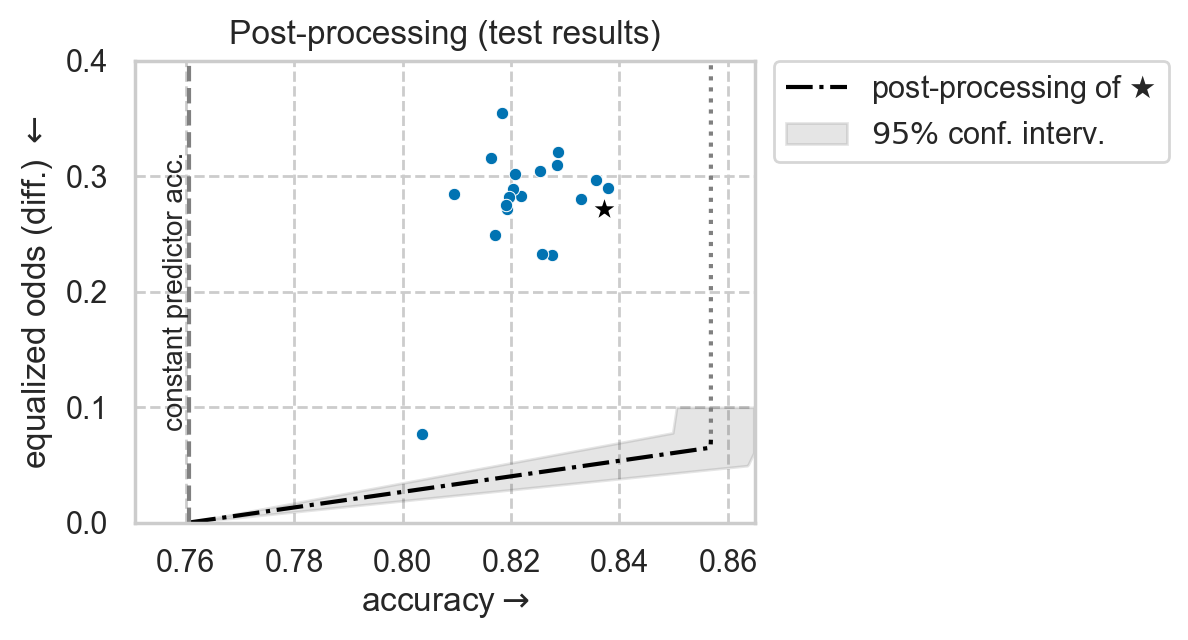

In [16]:
from utils.plotting import plot_postprocessing_frontier

# Plot all unconstrained models
sns.scatterplot(
    data=hpt_results.drop(index=obj_func.best_trial.id),
    x=PERF_METRIC,
    y=DISP_METRIC,
    s=20,
)

# Plot best unconstrained model
sns.scatterplot(
    x=[best_trial_results[PERF_METRIC]],
    y=[best_trial_results[DISP_METRIC]],
    color="black",
    marker="*",
    s=100,
)

# Plot postprocessing of unconstrained model
plot_postprocessing_frontier(
    postproc_results_df,
    perf_metric=PERF_METRIC,
    disp_metric=DISP_METRIC,
    show_data_type=SHOW_RESULTS_ON,
    model_name=r"$\bigstar$",
    constant_clf_accuracy=constant_clf_accuracy[SHOW_RESULTS_ON],
)

# Vertical line with minimum "useful" accuracy on this data
curr_const_clf_acc = constant_clf_accuracy[SHOW_RESULTS_ON]
plt.axvline(
    x=curr_const_clf_acc,
    ls="--",
    color="grey",
)
plt.gca().annotate(
    "constant predictor acc.",
    xy=(curr_const_clf_acc, ax_kwargs["ylim"][1] / 2),
    zorder=10,
    rotation=90,
    horizontalalignment="right",
    verticalalignment="center",
    fontsize="small",
    
)

# Title and legend
ax_kwargs["title"] = f"Post-processing ({SHOW_RESULTS_ON} results)"
ax_kwargs["xlim"] = (curr_const_clf_acc - 1e-2, 0.865)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.03, 1),
    borderaxespad=0)

plt.gca().set(**ax_kwargs)
save_current_fig(f"postprocessing-unconstr.{SHOW_RESULTS_ON}")

plt.show()

### Let's train another type of fairness-aware model

**In-processing** fairness methods introduce fairness criteria during model training.

_Main disadvantage_: state-of-the-art in-processing methods can be considerably slower to run (e.g., increasing training time by 20-100 times).

We'll be using the [`fairlearn`](https://github.com/fairlearn/fairlearn) package [[Weerts et al., 2020]](https://arxiv.org/abs/2303.16626).

In [17]:
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from lightgbm import LGBMClassifier

inproc_clf = ExponentiatedGradient(
    # estimator=unconstr_clf,
    estimator=LGBMClassifier(verbosity=-1),
    constraints=EqualizedOdds(),
    max_iter=10,
)

Fit the `ExponentiatedGradient` [[Agarwal et al., 2018]](https://proceedings.mlr.press/v80/agarwal18a.html) in-processing intervention (**note**: may take a few minutes to fit).

In [18]:
%%time
inproc_clf.fit(X_train, y_train, sensitive_features=s_train)

CPU times: user 46.5 s, sys: 58.3 s, total: 1min 44s
Wall time: 20.9 s


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x2914a0e20>,
                      estimator=LGBMClassifier(verbosity=-1), max_iter=10,
                      nu=0.0009193932718907877)

Evaluate in-processing model on test data.

In [19]:
from hpt.evaluation import evaluate_predictions_bootstrap

inproc_test_results = evaluate_predictions_bootstrap(
    y_true=y_test,
    y_pred_scores=inproc_clf.predict(X_test, random_state=SEED).astype(float),
    sensitive_attribute=s_test,
)

print(
    f"In-processing model: \n"
    f">       accuracy = {inproc_test_results['accuracy_mean']:.3}\n"
    f"> equalized odds = {inproc_test_results['equalized_odds_diff_mean']:.3}\n"
)

In-processing model: 
>       accuracy = 0.87
> equalized odds = 0.0536



**We can go one step further and post-process this in-processing model :)**

In [20]:
from utils.postprocessing import compute_postprocessing_curve

inproc_postproc_results_df = compute_postprocessing_curve(
    model=inproc_clf,
    y_fit_pred_scores=inproc_clf._pmf_predict(fit_data[0])[:, -1],
    predict_method="_pmf_predict",
    **compute_postproc_kwargs,
)

  0%|          | 0/28 [00:00<?, ?it/s]

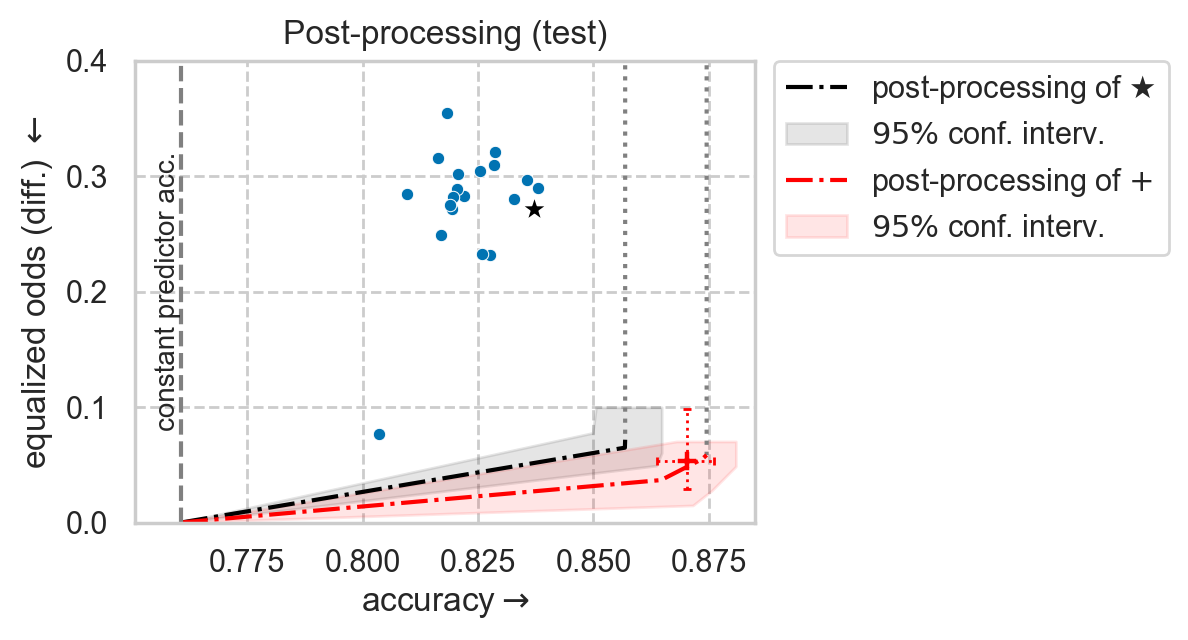

In [21]:
from utils.plotting import plot_postprocessing_frontier

# Plot all unconstrained models
sns.scatterplot(
    data=hpt_results.drop(index=obj_func.best_trial.id),
    x=PERF_METRIC,
    y=DISP_METRIC,
    s=20,
)

# Plot unconstrained model
sns.scatterplot(
    x=[best_trial_results[PERF_METRIC]],
    y=[best_trial_results[DISP_METRIC]],
    color="black",
    marker="*",
    s=100,
)

# Plot postprocessing of unconstrained model
plot_postprocessing_frontier(
    postproc_results_df,
    perf_metric=PERF_METRIC,
    disp_metric=DISP_METRIC,
    show_data_type=SHOW_RESULTS_ON,
    model_name=r"$\bigstar$",
    constant_clf_accuracy=constant_clf_accuracy[SHOW_RESULTS_ON],
)

# Plot inprocessing intervention results
sns.scatterplot(
    x=[inproc_test_results[f"{PERF_METRIC}_mean"]],
    y=[inproc_test_results[f"{DISP_METRIC}_mean"]],
    color="red",
    marker="P",
    s=50,
)

# Plot inprocessing results 95% CIs
plt.plot(
    (inproc_test_results[f"{PERF_METRIC}_low-percentile"], inproc_test_results[f"{PERF_METRIC}_high-percentile"]),
    (inproc_test_results[f"{DISP_METRIC}_mean"], inproc_test_results[f"{DISP_METRIC}_mean"]),
    color='red',
    ls=":",
    marker="|",
    lw=1,
    ms=3,
)

plt.plot(
    (inproc_test_results[f"{PERF_METRIC}_mean"], inproc_test_results[f"{PERF_METRIC}_mean"]),
    (inproc_test_results[f"{DISP_METRIC}_low-percentile"], inproc_test_results[f"{DISP_METRIC}_high-percentile"]),
    color='red',
    ls=":",
    marker="_",
    lw=1,
    ms=3,
)

# Plot postprocessing of inprocessing model
plot_postprocessing_frontier(
    inproc_postproc_results_df,
    perf_metric=PERF_METRIC,
    disp_metric=DISP_METRIC,
    show_data_type=SHOW_RESULTS_ON,
    # model_name=r"$\blacksquare$",
    model_name=r"$+$",
    constant_clf_accuracy=constant_clf_accuracy[SHOW_RESULTS_ON],
    color="red",
)

# Vertical line with minimum "useful" accuracy on this data
curr_const_clf_acc = constant_clf_accuracy[SHOW_RESULTS_ON]
plt.axvline(
    x=curr_const_clf_acc,
    ls="--",
    color="grey",
)
plt.gca().annotate(
    "constant predictor acc.",
    xy=(curr_const_clf_acc, ax_kwargs["ylim"][1] / 2),
    zorder=10,
    rotation=90,
    horizontalalignment="right",
    verticalalignment="center",
    fontsize="small",
    
)

# Title and legend
ax_kwargs["title"] = f"Post-processing ({SHOW_RESULTS_ON})"
ax_kwargs["xlim"] = (curr_const_clf_acc - 1e-2, 0.885)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.03, 1),
    borderaxespad=0)

plt.gca().set(**ax_kwargs)
save_current_fig(f"postprocessing-and-inprocessing.{SHOW_RESULTS_ON}")

plt.show()

---